# PlantSpy 2- Classification Corn

## Importer les librairies et connection au Drive

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
import os
import pathlib
from PIL import Image 
from sklearn.model_selection import train_test_split
%matplotlib inline

from matplotlib import cm

from imblearn.under_sampling import RandomUnderSampler

from tensorflow.keras.layers import Input, Dense 
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D 
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras import Sequential
from tensorflow.keras import callbacks

from tensorflow.keras.applications.vgg16 import VGG16


from sklearn import metrics # Pour évaluer les modèles

import itertools # Pour créer des iterateurs

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Recuperation des donnees:


#### Train Dataset

In [ ]:
# folder_path = "/content/drive/MyDrive/Kaggle/new-plant-diseases-dataset/train/"
folder_path = "/content/drive/MyDrive/NewPlantDiseasesDataset/train/"

X_train0=[]
y_train0=[]

width = 100
height = 100 # resize to 100x100 to solve the RAM issue in Kaggle notebooks

for path, dirs, files in os.walk(folder_path):
    for repertoire in dirs:
      if ("Corn" in repertoire) : # and ("healthy" not in repertoire ): # On recupere que les Tomates et que les healthy
        chemin=folder_path+repertoire
        for images in os.listdir(chemin):
          img=cv2.imread(chemin+'/'+images,cv2.IMREAD_COLOR )
          img_resized = cv2.resize(img, (width,height))
          X_train0.append(np.array(img_resized))
          y_train0.append(repertoire.split('___')[1])   # On recupere le type de maladie seulement 

In [ ]:
X_train0 = np.array(X_train0)
X_train0 = X_train0.astype('float32')


In [ ]:
y_train0= np.array(y_train0)

In [ ]:
X_train0.shape

(7316, 100, 100, 3)

In [ ]:
print(pd.DataFrame(y_train0).value_counts())

Northern_Leaf_Blight                   1908
Common_rust_                           1907
healthy                                1859
Cercospora_leaf_spot Gray_leaf_spot    1642
dtype: int64


#### Valid Dataset

In [ ]:
folder_path = "/content/drive/MyDrive/NewPlantDiseasesDataset/valid/"

X_valid0=[]
y_valid0=[]

width = 100
height = 100 # resize to 100x100 to solve the RAM issue in Kaggle notebooks

for path, dirs, files in os.walk(folder_path):
    for repertoire in dirs:
      if ("Corn" in repertoire) : #and ("healthy" not in repertoire): # On recupere que les Tomates et que les malades
        chemin=folder_path+repertoire
        for images in os.listdir(chemin):
          img=cv2.imread(chemin+'/'+images,cv2.IMREAD_COLOR )
          img_resized = cv2.resize(img, (width,height))
          X_valid0.append(np.array(img_resized))
          y_valid0.append(repertoire.split('___')[1])   # On recupere le type de maladie seulement 


In [ ]:
X_valid0= np.array(X_valid0)
X_valid0 = X_valid0.astype('float32')

y_valid0= np.array(y_valid0)

In [ ]:
X_valid0.shape

(1829, 100, 100, 3)

In [ ]:
pd.DataFrame(y_valid0).value_counts()

Common_rust_                           477
Northern_Leaf_Blight                   477
healthy                                465
Cercospora_leaf_spot Gray_leaf_spot    410
dtype: int64

## DataViz

In [ ]:
# Diviser les pixels des données X_train et X_test par 255 afin qu'ils soient compris entre 0 et 1
X_train = X_train0 / 255
X_valid = X_valid0 / 255

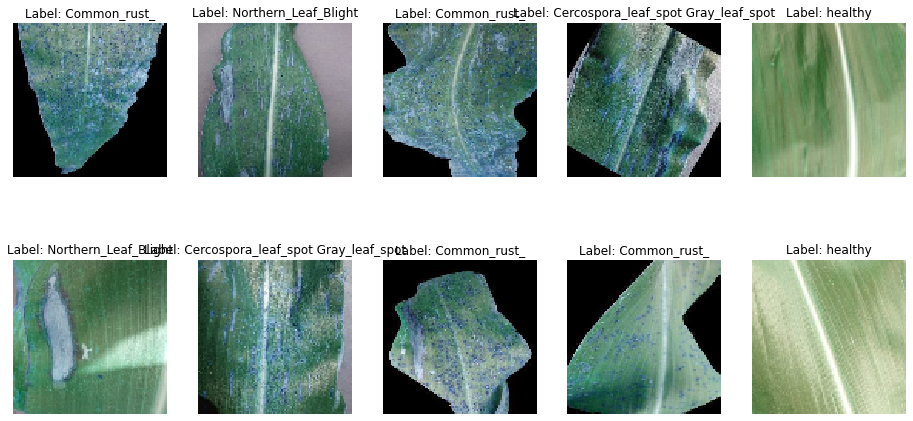

In [ ]:
plt.subplots(2, 5, figsize=(16, 8))

j = 1

for i in np.random.choice(np.arange(0, len(X_train)), size = 10):
    # Image
    img =X_train[i]
    
    
    # Subplot nous permet de selectionner une des sous-figures parmi une grille. Dans notre cas la grille
    # a 2 lignes et 3 colonnes.
    plt.subplot(2, 5, j)
    j = j + 1
    
    # Suppresion des axes
    plt.axis('off')
    
    # Affichage de la figure
    plt.imshow(img, interpolation='None')

    # Modification du titre de la figure
    plt.title('Label: ' + str(y_train0[i]))

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


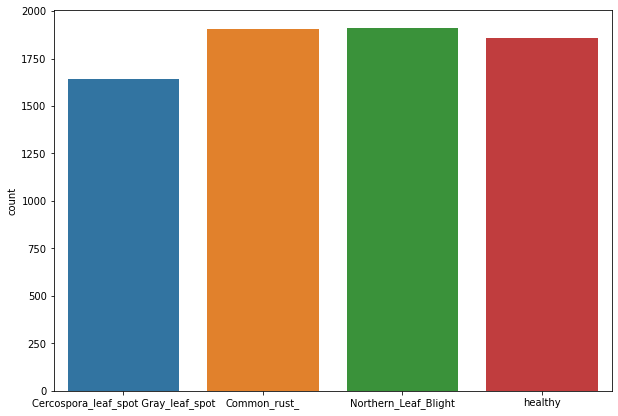

In [ ]:
import seaborn as sns

plt.figure(figsize=(10, 7))

sns.countplot(y_train0);
#plt.xticks(rotation=90);

In [ ]:
pd.DataFrame(y_train0).value_counts()

Northern_Leaf_Blight                   1908
Common_rust_                           1907
healthy                                1859
Cercospora_leaf_spot Gray_leaf_spot    1642
dtype: int64

## Preprocessing

In [ ]:
# Diviser les pixels des données X_train et X_test par 255 afin qu'ils soient compris entre 0 et 1
X_train = X_train0 / 255
X_valid = X_valid0 / 255

In [ ]:
from sklearn.preprocessing import LabelEncoder
encoder =  LabelEncoder()
y_train = encoder.fit_transform(y_train0)
y_valid = encoder.transform(y_valid0)

In [ ]:
# Pour retrouver facilement les noms des labels
# not used to delete IEL
dict_maladie_Corn = { 3: 'Northern_Leaf_Blight' ,
                 2: 'healthy',
                 1: 'Common_rust_' ,
                 0 : 'Cercospora_leaf_spot Gray_leaf_spot'}

list_maladie_Corn =[ 'Cercospora_leaf_spot Gray_leaf_spot', 'Common_rust_' , 'healthy', 'Northern_Leaf_Blight' ]



In [ ]:
# Shape of X_train and y_train
print('Shape of X Train:', X_train.shape)
print('Shape of y train:',y_train.shape)

print('Shape of X valid:', X_valid.shape)
print('Shape of y valid:',y_valid.shape)

Shape of X Train: (7316, 100, 100, 3)
Shape of y train: (7316,)
Shape of X valid: (1829, 100, 100, 3)
Shape of y valid: (1829,)


In [ ]:
pd.DataFrame(y_valid).value_counts()

1    477
2    477
3    465
0    410
dtype: int64

## Callbacks

In [ ]:
early_stopping = callbacks.EarlyStopping(monitor = 'val_loss',
                        patience = 8,
                        mode = 'min',
                        restore_best_weights = True)

lr_plateau = callbacks.ReduceLROnPlateau(monitor = 'val_loss',
                            patience=4,
                            factor=0.5,
                            verbose=2,
                            mode='min')

## Generateur de donnees

In [ ]:
train_data_generator = ImageDataGenerator(
        rotation_range=50,
        width_shift_range=1,
        height_shift_range=1,
        zoom_range=[0.7, 1.2],
        horizontal_flip=True)

test_data_generator = ImageDataGenerator()

In [ ]:
batch_size = 100

training_data = train_data_generator.flow(X_train, y_train, batch_size=batch_size)
test_data = test_data_generator.flow(X_valid, y_valid, batch_size=batch_size)

# 1er Modele: Architecture LeNet avec generateur d'images

#### Architecture Lenet

In [ ]:
input_shape = (100,100,3)

In [ ]:
model_Corn = Sequential()
model_Corn.add(Conv2D(filters=30, kernel_size=(5, 5), padding='valid', input_shape=input_shape, activation='relu'))
model_Corn.add(MaxPooling2D(pool_size=(3, 3)))
model_Corn.add(Dropout(rate=0.2))
model_Corn.add(Conv2D(filters=64, kernel_size=(3, 3), padding='valid', activation='relu'))
model_Corn.add(MaxPooling2D(pool_size=(2, 2)))
model_Corn.add(Conv2D(filters=32, kernel_size=(3, 3), padding='valid', activation='relu'))
model_Corn.add(MaxPooling2D(pool_size=(2, 2)))
model_Corn.add(Dropout(rate=0.2))
model_Corn.add(Flatten())
model_Corn.add(Dense(units=64, activation='relu'))
model_Corn.add(Dense(units=9, activation='sigmoid'))

In [ ]:
model_Corn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model_Corn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 96, 30)        2280      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 30)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 32, 32, 30)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 64)        17344     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 15, 15, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 13, 13, 32)        1

In [ ]:
history_Corn = model_Corn.fit_generator(generator = training_data, 
                              epochs = 20,
                              steps_per_epoch = len(X_train)//batch_size,
                              validation_data = test_data,
                              validation_steps = len(X_valid)//batch_size,
                              callbacks = [early_stopping,lr_plateau])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/20
73/73 [==============================] - 56s 757ms/step - loss: 0.9630 - accuracy: 0.5754 - val_loss: 0.4837 - val_accuracy: 0.7950 - lr: 0.0010
Epoch 2/20
73/73 [==============================] - 55s 756ms/step - loss: 0.4615 - accuracy: 0.7961 - val_loss: 0.3528 - val_accuracy: 0.8667 - lr: 0.0010
Epoch 3/20
73/73 [==============================] - 55s 756ms/step - loss: 0.3931 - accuracy: 0.8228 - val_loss: 0.3626 - val_accuracy: 0.8522 - lr: 0.0010
Epoch 4/20
73/73 [==============================] - 55s 751ms/step - loss: 0.3761 - accuracy: 0.8340 - val_loss: 0.3030 - val_accuracy: 0.8956 - lr: 0.0010
Epoch 5/20
73/73 [==============================] - 56s 765ms/step - loss: 0.3026 - accuracy: 0.8701 - val_loss: 0.2322 - val_accuracy: 0.9267 - lr: 0.0010
Epoch 6/20
73/73 [==============================] - 55s 755ms/step - loss: 0.2735 - accuracy: 0.8918 - val_loss: 0.1824 - val_accuracy: 0.9378 - lr: 0.0010
Epoch 7/20
73/73 [==============================] - 55s 754ms/st

In [ ]:
model_Corn.save('/content/drive/MyDrive/model_Corn_Healthy')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/model_Corn_Healthy/assets


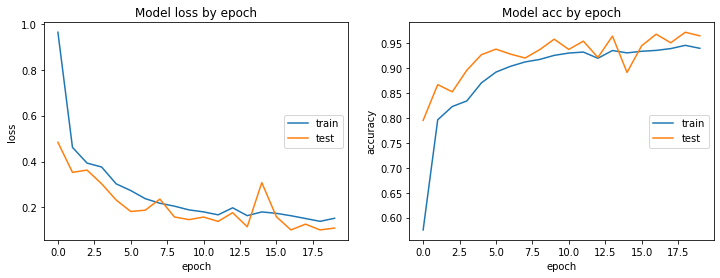

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(history_Corn.history['loss'])
plt.plot(history_Corn.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')

plt.subplot(122)
plt.plot(history_Corn.history['accuracy'])
plt.plot(history_Corn.history['val_accuracy'])
plt.title('Model acc by epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right');

In [ ]:
test_pred_Corn = model_Corn.predict(X_valid)

test_pred_Corn_class = test_pred_Corn.argmax(axis = 1)

In [ ]:
test_pred_Corn_label = encoder.inverse_transform(test_pred_Corn_class)
y_valid_label =encoder.inverse_transform( y_valid)


In [ ]:
print(metrics.classification_report(y_valid_label, test_pred_Corn_label))

                                     precision    recall  f1-score   support

Cercospora_leaf_spot Gray_leaf_spot       0.56      0.95      0.71       410
                       Common_rust_       0.99      0.46      0.63       477
               Northern_Leaf_Blight       0.96      0.90      0.93       477
                            healthy       1.00      0.98      0.99       465

                           accuracy                           0.82      1829
                          macro avg       0.88      0.83      0.81      1829
                       weighted avg       0.89      0.82      0.82      1829



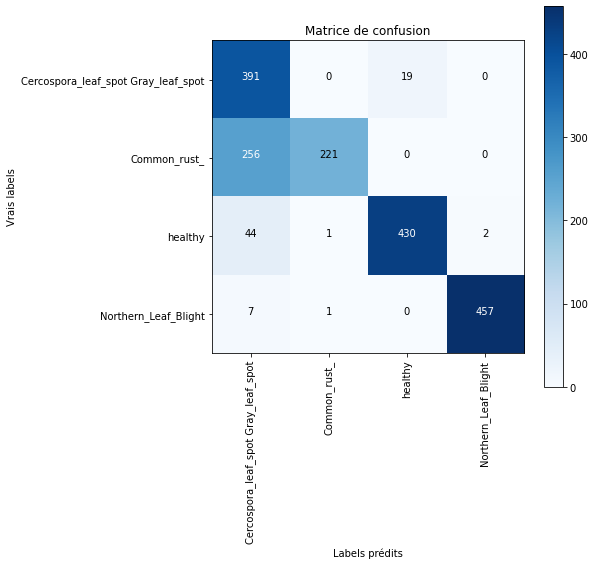

In [ ]:
# Matrice de Confusion

cnf_matrix = metrics.confusion_matrix(y_valid_label, test_pred_Corn_label )

max_category =  pd.DataFrame(y_train0).value_counts().shape[0]
classes = range(0,max_category)
plt.figure(figsize=(7, 7))


plt.imshow(cnf_matrix, interpolation='nearest',cmap='Blues')
plt.title("Matrice de confusion")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
    plt.text(j, i, cnf_matrix[i, j],
             horizontalalignment="center",
             color="white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")

plt.yticks(np.arange(0, max_category), list_maladie_Corn )
plt.ylabel('Vrais labels')
plt.xticks(np.arange(0, max_category),list_maladie_Corn, rotation = 90)

plt.xlabel('Labels prédits')

plt.show()

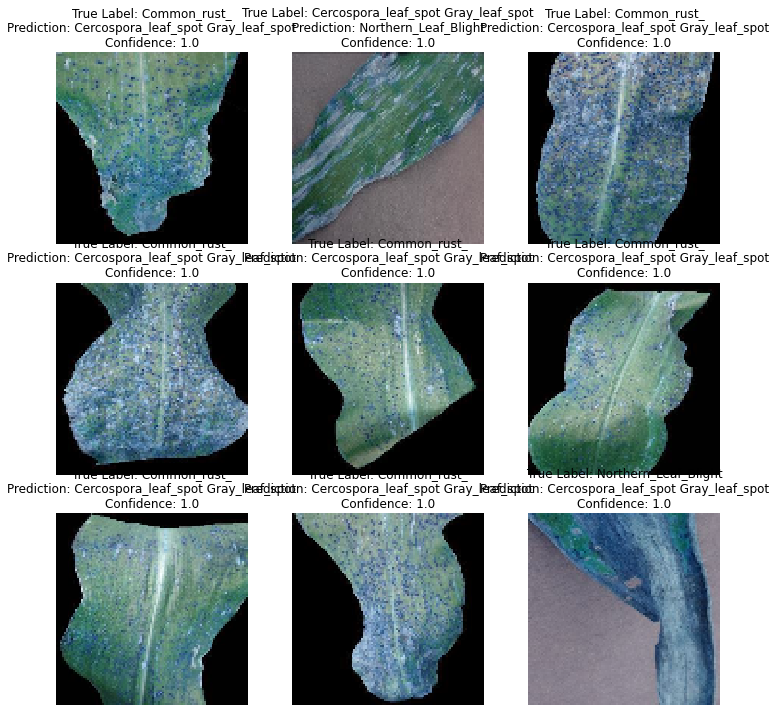

In [ ]:
# voir les images de la base de test où le modele se trompe

plt.subplots(3, 3, figsize=(12, 12))

error_indexes = []
for i in range(len(test_pred_Corn)):
    if (test_pred_Corn_label[i] != y_valid_label[i]):
      error_indexes += [i]

j = 1
for i in np.random.choice(error_indexes, size = 9):
    img = X_valid[i] 
    img = img.reshape(100, 100,3)
    
    plt.subplot(3, 3, j)
    j = j + 1
    plt.axis('off')
    plt.imshow(img,cmap = cm.binary, interpolation='None')
    plt.title('True Label: ' + str(y_valid_label[i]) \
              + '\n' + 'Prediction: '+ str(test_pred_Corn_label[i]) \
              + '\n' + 'Confidence: '+ str(round(test_pred_Corn[i,test_pred_Corn_class[i]], 2)))